In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

if cv2.__version__ != '3.1.0':
    raise "Incorrection Module Version"

# SIFT (Surface Invariant Feature Transform)
Previously discussed corner detectors (Harris and Shi-Tomasi) were rotation invariant. But when it comes to images of different scales, matching features becomes a common problem.

<center>Normal Detectors<img src="../resources/scaling.jpg"></center>

SIFT can work even after changing following parameters(other than scale. duh!):
- Rotation
- Illumination
- Viewpoint

### Breaking down and understanding the algorithm
#### 1. Constructing a scale space
You take the original image, and generate progressively blurred out images. Then, you resize the original image to half size. And you generate blurred out images again. And you keep repeating.
<img src="../resources/octave.jpg">
We generate several octaves of the original image. Each octave's image is half the size of previous one. In each octave, images are progressively blurred using the Gaussian Blur operator. Generally, 4 octaves and 5 blur levels are considered ideal for the algorithm.
#### 2. LoG (Laplacian of Gaussian) Approximations
From color space, we take images, blur them and calculate second order derivatives (Laplacian), which provides corners and edges. As second order derivatives are extremely sensitive to noise, it's necessary to apply blur in order to supress noise.

LOG is computationally heavy, so we opt for DoG (Difference of Gaussian), which produces approximately equivalent outputs as LoG, and is faster (less computations).

Two consecutive images in an octave are picked and subtracted. Then the next consecutive pair is taken, and the process repeats. This is done for all octaves. The resulting images are an approximation of scale invariant LoG (which is good for detecting keypoints).

$$L(x, y, \sigma) = G(x, y, \sigma) * I(x, y)$$

$$\sigma\text{ is the scale parameter. More is it's value, more is the blur}$$

$$\text{If amount of blur in an image of an octave is }\sigma\text{, then amount of blur for next image in the same octave will be }k\sigma\text{, where k is any constant}$$

$$\text{Across octaves, }\sigma\text{ varies, and withing octaves, constant 'k' varies}$$
<img src="../resources/blur_amount.jpg">
#### 3. Keypoints Localization in DoG images
<img src="../resources/sift_local_extrema.jpg">
Each pixel is compared to it's 8 neighbours and 3x3 corresponding windows in image above and below it. Suppose, X is the pixel being compared here. It's marked as a keypoint if it's greatest or least among the 26(8 + 3x3 + 3x3) neighbours. Now, the approximate maxima and minima are located. To find accurate positions, we apply sub pixel accuracy method.

Using the available pixel data, subpixel values are generated. This is done by the Taylor expansion of the image around the approximate key point. We just need to find extreme points of the equation:
$$D(X) = D + (\frac{\delta D}{\delta X})^{T}X + \frac{1}{2}X^T\frac{\delta^{2}D}{\delta X^2}X$$
$$\text{D(X) is scale-space function, X = }(x, y, \sigma)^T$$
#### 4. Refining Keypoints
Remember that DoG contains not only corners but also edges. So, now we'll reject the low contrast and edge region keypoints.

<u>Removing low contrast keypoints</u>: If magnitude of current pixel in DoG image is less than a threshold, it's rejected. After this, we use taylor expansion to get intensity value at sub-pixel locations. If this is less than the threshold, the keypoint is rejected.

<u>Removing edge region keypoints</u>: A 2x2 Hessian matrix is used to calculate principal curvature, which is then used to find eigen values for the shape operator. We know that for edges, one eigen value is greater than the other. This way, edge region keypoinds are discarded as well.
#### 5. Rotation Invariance
A neighbourhood is taken around a keypoint depending on the scale, and gradient magnitude and direction is calculated in that region.
$$m(x, y) = \sqrt{(L(x+1, y) - L(x-1, y))^2 + (L(x, y+1) - L(x, y-1))^2}$$
$$\theta(x, y) = \tan^{-1}\frac{L(x, y+1) - L(x, y-1)}{L(x+1, y) - L(x-1, y)}$$
A histogram is made in which, the 360 degrees of orientation are broken into 36 bins (each of 10 degrees). The keypoint is assigned the index of the bin with maximum peak in the histogram. Also, all the other peaks above 80% of the maximum peak are converted to a new keypoint.
#### 6. Keypoint Descriptor
A 16x16 neigbourhood around the keypoint is taken, and is divided into 16 4x4 sub-blocks. For each 4x4 block, gradient magnitudes and orientations are calculated. These orientations are put into an 8 bin histogram. A gaussian weighting function is used to alter the orientation magnitudes before feeding them into the histogram. So total of 128 (4*4*8) bin values are available for each keypoint, which are then normalized. These numbers form "feature vector" or "feature descriptor", and it's unique for every keypoint.

<u><b>Use of descriptors</b></u>: Keypoint extraction only gives coverage area and position of keypoints, which may be sometimes not that useful alone.

Example, suppose we have an image A (of a bear on a white background), and another image B, exact copy of A but translated for a few pixels: the extracted keypoints will be the same (on the same part of that bear). Those two images should be recognized as similar. But, if the only information we have is position of keypoints, then we can't compare the images as the keypoints of image B will be translated as well.

*Descripors* help here by encoding some characteristics about keypoints in a vector format, and providing a way to compare different keypoints.
#### 7. Final Touch
As feature vetors depend on gradient orientations, rotating the image will change the vector as well. But we want it to be rotation invariant. So, keypoint's orientation is subtracted from each orienation to make it each gradient orientation realtive to the orientation of the keypoint. Thresholding will provide the illumination invariance.

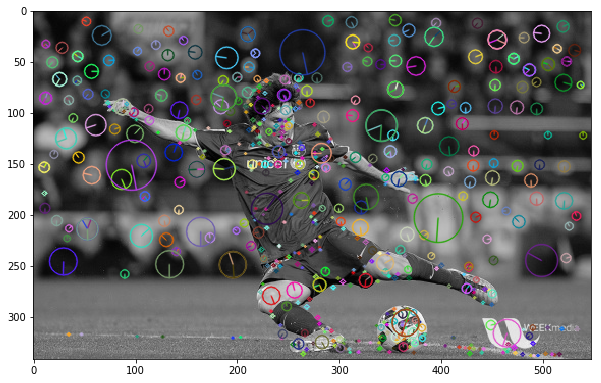

In [2]:
image = cv2.imread("../resources/messi.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

try:
    sift = cv2.SIFT()
except:
    sift = cv2.xfeatures2d.SIFT_create()

kp, descriptors = sift.detectAndCompute(gray, mask=None)
# print descriptors
# print len(kp), descriptors.shape

flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT
try:
    image = cv2.drawKeypoints(gray, kp, flags=flags)
except:
    cv2.drawKeypoints(gray, kp, image, flags=flags)

fig = plt.figure()
fig.set_size_inches(10, 10)
fig.add_subplot(1,1,1)
plt.imshow(image)
plt.show()

In [3]:
# Let's get our hands dirty :D
# Now we'll try to implement our own SIFT
import math
import random


class Descriptor(object):
    def __init__(self, x, y, feature_vector):
        self.x = x
        self.y = y
        self.feature_vector = feature_vector


class Keypoint(object):
    def __init__(self, x, y, magnitude, orientation, scale):
        self.x = x
        self.y = y
        self.magnitude = magnitude
        self.orientation = orientation
        self.scale = scale


class SIFT(object):
    def __init__(self, image, octaves, intervals):
        # CONSTANTS
        self.sigma_antialias = 0.5
        self.sigma_preblur = 1.0
        self.edge_threshold = 7.2
        self.intensity_threshold = 0.05
        self.pi = 3.1415926535897932384626433832795
        self.bins = 36
        self.max_kernel_dim = 20
        self.feature_win_dim = 16
        self.descriptor_bins = 8
        self.feature_vector_size = 128
        self.feature_vector_threshold = 0.2
        self.num_keypoints = 0
        self.keypoints = []
        self.descriptors = []
        
        self.image = image.copy()  # colored image (BGR format)
        self.octaves = octaves
        self.intervals = intervals
        
        self.gaussian = [[None for interval in range(self.intervals + 3)] for octave in range(self.octaves)]
        self.dog = [[None for interval in range(self.intervals + 2)] for octave in range(self.octaves)]
        self.extrema = [[None for interval in range(self.intervals)] for octave in range(self.octaves)]
        self.sigma_level =[[None for interval in range(self.intervals + 3)] for octave in range(self.octaves)]
        
    def build_scale_space(self):
        gray = np.float32(cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY))
        
        for i in range(gray.shape[0]):
            for j in range(gray.shape[1]):
                gray[i, j] /= 255.0
        
        ksize = int(3 * self.sigma_antialias)
        if ksize % 2 == 0: ksize += 1
        gray = cv2.GaussianBlur(gray, (ksize, ksize), self.sigma_antialias)
        
        self.gaussian[0][0] = np.float32(cv2.pyrUp(gray))
        ksize = int(3 * self.sigma_preblur)
        if ksize % 2 == 0: ksize += 1
        self.gaussian[0][0] = np.float32(
            cv2.GaussianBlur(self.gaussian[0][0], (ksize, ksize), self.sigma_preblur)
        )
        
        sigma_init = math.sqrt(2.0)
        self.sigma_level[0][0] = sigma_init * 0.5
        
        for i in range(self.octaves):
            sigma = sigma_init
            
            for j in range(1, self.intervals + 3):
                sigma_next = math.sqrt((2 ** (2.0 / self.intervals)) - 1) * sigma
                sigma *= 2 ** (1.0 / self.intervals)
                
                self.sigma_level[i][j] = sigma * 0.5 * (2 ** i)
                ksize = int(3 * sigma_next)
                if ksize % 2 == 0: ksize += 1
                
                self.gaussian[i][j] = np.float32(
                    cv2.GaussianBlur(self.gaussian[i][j - 1], (ksize, ksize), sigma_next)
                )
                
                self.dog[i][j - 1] = np.float32(cv2.subtract(self.gaussian[i][j - 1], self.gaussian[i][j]))
            
            if i != self.octaves - 1:
                self.gaussian[i + 1][0] = np.float32(cv2.pyrDown(self.gaussian[i][0]))
                self.sigma_level[i + 1][0] = self.sigma_level[i][self.intervals]
    
    def detect_extrema(self):
        num_keypoints = 0
        
        for i in range(self.octaves):
            for j in range(1, self.intervals + 1):
                self.extrema[i][j - 1] = np.float32(np.zeros_like(self.dog[i][0]))
                
                middle = self.dog[i][j]
                above = self.dog[i][j + 1]
                below = self.dog[i][j - 1]
                
                for x in range(1, self.dog[i][j].shape[0] - 1):
                    for y in range(1, self.dog[i][j].shape[1] - 1):
                        flag = False
                        
                        pixel = middle[x, y]
                        
                        # Sigh! Have to check against 26 pixel if you remember (9 + 9 + 8)
                        values = [
                            middle[x - 1, y - 1], middle[x, y - 1], middle[x + 1, y - 1],
                            middle[x - 1, y], middle[x, y], middle[x + 1, y],
                            middle[x - 1, y + 1], middle[x, y + 1], middle[x + 1, y + 1],
                            
                            above[x - 1, y - 1], above[x, y - 1], above[x + 1, y - 1],
                            above[x - 1, y], above[x, y], above[x + 1, y],
                            above[x - 1, y + 1], above[x, y + 1], above[x + 1, y + 1],
                            
                            below[x - 1, y - 1], below[x, y - 1], below[x + 1, y - 1],
                            below[x - 1, y], below[x, y], below[x + 1, y],
                            below[x - 1, y + 1], below[x, y + 1], below[x + 1, y + 1]
                        ]
                        values.sort()
                        
                        # Check for maxmima
                        if values[-1] == pixel and values[-1] != values[-2]:
                            flag = True
                            self.extrema[i][j - 1][x, y] = 255
                            num_keypoints += 1
                        # Check for minima
                        elif values[0] == pixel and values[0] != values[1]:
                            flag = True
                            self.extrema[i][j - 1][x, y] = 255
                            num_keypoints += 1
                        
                        # Intensity check
                        if flag and math.fabs(middle[x, y]) < self.intensity_threshold:
                            self.extrema[i][j - 1][x, y] = 0
                            num_keypoints -= 1
                            flag = False
                        
                        # Edge check
                        if flag:
                            # Using Hessian Matrix
                            dx2 = middle[x, y - 1] + middle[x, y + 1] - 2 * middle[x, y]
                            dy2 = middle[x - 1, y] + middle[x + 1, y] - 2 * middle[x, y]
                            dxy = (
                                middle[x - 1, y - 1] + 
                                middle[x - 1, y + 1] + 
                                middle[x + 1, y - 1] + 
                                middle[x + 1, y + 1]
                            )
                            dxy /= 4.0
                            
                            tr = dx2 + dy2
                            det = dx2 * dy2 + dxy ** 2
                            
                            curvature_ratio = (tr ** 2) / det
                            if det < 0 or curvature_ratio > self.edge_threshold:
                                self.extrema[i][j - 1][x, y] = 0
                                num_keypoints -= 1

        self.num_keypoints = num_keypoints
    
    def assign_orientation(self):
        magnitudes = [[None for interval in range(self.intervals)] for octave in range(self.octaves)]
        orientations = [[None for interval in range(self.intervals)] for octave in range(self.octaves)]
        
        for i in range(self.octaves):
            for j in range(1, self.intervals):
                magnitudes[i][j - 1] = np.float32(np.zeros_like(self.gaussian[i][j]))
                orientations[i][j - 1] = np.float32(np.zeros_like(self.gaussian[i][j]))
                
                for x in range(1, self.gaussian[i][j].shape[0] - 1):
                    for y in range(1, self.gaussian[i][j].shape[1] - 1):
                        # Calculate gradient
                        dx = self.gaussian[i][j][x + 1, y] - self.gaussian[i][j][x - 1, y]
                        dy = self.gaussian[i][j][x, y + 1] - self.gaussian[i][j][x, y - 1]
                        
                        magnitudes[i][j - 1][x, y] = math.sqrt(dx ** 2 + dy ** 2)
                        orientations[i][j - 1][x, y] = math.atan2(dy, dx)
        
        for i in range(self.octaves):
            scale = 2.0 ** i
            
            for j in range(1, self.intervals):
                sigma = self.sigma_level[i][j]
                
                ksize = int(3 * 1.5 * sigma)
                if ksize % 2 == 0: ksize += 1
                
                weighted = np.float32(cv2.GaussianBlur(magnitudes[i][j - 1], (ksize, ksize), 1.5 * sigma))
                approx_gaussian_kernel_size = ksize // 2
                
                mask = np.float32(np.zeros_like(self.gaussian[i][0]))
                
                for x in range(self.gaussian[i][0].shape[0]):
                    for y in range(self.gaussian[i][0].shape[1]):
                        if self.extrema[i][j - 1][x, y] != 0:
                            orientation_hist = [0.0 for b in range(self.bins)]
                            
                            for ii in range(-approx_gaussian_kernel_size, approx_gaussian_kernel_size + 1):
                                for jj in range(-approx_gaussian_kernel_size, approx_gaussian_kernel_size + 1):
                                    if x + ii < 0 or x + ii >= self.gaussian[i][0].shape[0]: continue
                                    if y + jj < 0 or y + jj >= self.gaussian[i][0].shape[1]: continue
                                    
                                    sampled_orientation = orientations[i][j - 1][x + ii, y + jj]
                                    sampled_orientation += self.pi
                                    
                                    degrees = sampled_orientation * 180 / self.pi
                                    orientation_hist[int(degrees * self.bins / 360)] += weighted[x + ii, y + jj]
                                    
                                    mask[x + ii, y + jj] = 255
                            
                            max_peak = max(orientation_hist)
                            max_peak_index = orientation_hist.index(max_peak)
                            
                            o = []
                            m = []
                            
                            for k in range(self.bins):
                                if orientation_hist[k] > 0.8 * max_peak:
                                    x1 = k - 1
                                    x2 = k
                                    y2 = orientation_hist[k]
                                    x3 = k + 1
                                    
                                    if k == 0:
                                        y1 = orientation_hist[self.bins - 1]
                                        y3 = orientation_hist[k + 1]
                                    elif k == self.bins - 1:
                                        y1 = orientation_hist[k - 1]
                                        y3 = orientation_hist[0]
                                    else:
                                        y1 = orientation_hist[k - 1]
                                        y3 = orientation_hist[k + 1]
                                    
                                    # Fit a down facing parabola to the above points (x1, y1), (x2, y2), (x3, y3)
                                    # y = a*x*x + b*x + c
                                    # y1 = a*x1*x1 + b*x1 + c
                                    # y1 = a*x2*x2 + b*x2 + c
                                    # y1 = a*x3*x3 + b*x3 + c
                                    # Y = X * Transpose([a, b, c]) (= L, say)
                                    # L = inverse(X) * Y
                                    
                                    X = np.array([
                                        [x1*x1, x1, 1],
                                        [x2*x2, x2, 1],
                                        [x3*x3, x3, 1]
                                    ])
                                    
                                    Y = np.array([
                                        [y1],
                                        [y2],
                                        [y3]
                                    ])
                                    
                                    L = np.dot(np.invert(X), Y)
                                    
                                    # So, now we have a,b,c for our parabola equation,let's find vertex
                                    x0 = -L[1] / (2 * L[0])
                                    if math.fabs(x0) > 2 * self.bins: x0 = x2
                                    while(x0 < 0): x0 += self.bins
                                    while(x0 > self.bins): x0 -= self.bins
                                    
                                    x0_normalized = x0 * (2 * self.pi / self.bins)
                                    x0_normalized -= self.pi
                                    
                                    o.append(x0_normalized)
                                    m.append(orientation_hist[k])
                            
                            self.keypoints.append(Keypoint(
                                x * scale / 2.0, y * scale / 2.0, m, o, i * self.intervals + j - 1
                            ))

    def generate_features(self):
        magnitudes_interpolated = [
            [
                None for interval in range(self.intervals)
            ] for octave in range(self.octaves)
        ]
        orientations_interpolated = [
            [
                None for interval in range(self.intervals)
            ] for octave in range(self.octaves)
        ]
        
        for i in range(self.octaves):
            for j in range(1, self.intervals + 1):
                temp = np.float32(cv2.pyrUp(self.gaussian[i][j]))
                
                magnitudes_interpolated[i][j - 1] = np.float32(
                    np.zeros_like(
                        cv2.resize(
                            self.gaussian[i][j],
                            (self.gaussian[i][j].shape[1] + 1, self.gaussian[i][j].shape[0] + 1)
                        )
                    )
                )
                orientations_interpolated[i][j - 1] = np.float32(
                    np.zeros_like(
                        cv2.resize(
                            self.gaussian[i][j],
                            (self.gaussian[i][j].shape[1] + 1, self.gaussian[i][j].shape[0] + 1)
                        )
                    )
                )
                
                ii = 1.5
                while(ii < self.gaussian[i][j].shape[0] - 1.5):
                    jj = 1.5
                    
                    while(jj < self.gaussian[i][j].shape[1] - 1.5):
                        ii1 = int(ii + 1.5)
                        ii2 = int(ii + 0.5)
                        ii3 = int(ii)
                        ii4 = int(ii - 0.5)
                        ii5 = int(ii - 1.5)
                        
                        jj1 = int(jj + 1.5)
                        jj2 = int(jj + 0.5)
                        jj3 = int(jj)
                        jj4 = int(jj - 0.5)
                        jj5 = int(jj - 1.5)
                        
                        dx = (
                            (self.gaussian[i][j][ii1, jj3] + self.gaussian[i][j][ii2, jj3]) / 2.0 -
                            (self.gaussian[i][j][ii5, jj3] + self.gaussian[i][j][ii4, jj3]) / 2.0
                        )
                        dy = (
                            (self.gaussian[i][j][ii3, jj1] + self.gaussian[i][j][ii3, jj2]) / 2.0 -
                            (self.gaussian[i][j][ii3, jj5] + self.gaussian[i][j][ii3, jj4]) / 2.0
                        )
                        
                        x_ = int(ii + 1)
                        y_ = int(jj + 1)
                        
                        magnitudes_interpolated[i][j - 1][x_, y_] = math.sqrt(dx ** 2 + dy ** 2)
                        if math.atan2(dy, dx) == self.pi: orientations_interpolated[i][j - 1][x_, y_] = -self.pi
                        else: orientations_interpolated[i][j - 1][x_, y_] = math.atan2(dy, dx)
                        
                        jj += 1
                    ii += 1
                
                for ii in range(self.gaussian[i][j].shape[0] + 1):
                    magnitudes_interpolated[i][j - 1][ii, 0] = 0
                    magnitudes_interpolated[i][j - 1][ii, self.gaussian[i][j].shape[1] - 1] = 0
                    orientations_interpolated[i][j - 1][ii, 0] = 0
                    orientations_interpolated[i][j - 1][ii, self.gaussian[i][j].shape[1] - 1] = 0
                
                for jj in range(self.gaussian[i][j].shape[1] + 1):
                    magnitudes_interpolated[i][j - 1][0, jj] = 0
                    magnitudes_interpolated[i][j - 1][self.gaussian[i][j].shape[0] - 1, jj] = 0
                    orientations_interpolated[i][j - 1][0, jj] = 0
                    orientations_interpolated[i][j - 1][self.gaussian[i][j].shape[0] - 1, jj] = 0
        
        G = self.interpolated_gaussian(self.feature_win_dim, 0.5 * self.feature_win_dim)
        
        buggy_keypoints = []

        for keypoint in self.keypoints:
            scale = keypoint.scale
            x = keypoint.x
            y = keypoint.y
            
            ii = int(x * 2) / int(2.0 ** (scale / self.intervals))
            jj = int(y * 2) / int(2.0 ** (scale / self.intervals))
            
            orientations = keypoint.orientation
            magnitudes = keypoint.magnitude
            
            main_orientation = orientations[0]
            main_magnitude = magnitudes[0]
            
            for i in range(len(magnitudes)):
                if magnitudes[i] > main_magnitude:
                    main_orientation = orientations[i]
                    main_magnitude = magnitudes[i]
            
            half_kernel_size = self.feature_win_dim / 2
            weights = np.float32(np.zeros((self.feature_win_dim, self.feature_win_dim)))
            
            for i in range(self.feature_win_dim):
                for j in range(self.feature_win_dim):
                    if ii + i + 1 < half_kernel_size:
                        weights[i, j] = 0
                    elif ii + i + 1 > half_kernel_size + self.gaussian[scale // self.intervals][0].shape[1]:
                        weights[i, j] = 0
                    elif jj + j + 1 < half_kernel_size:
                        weights[i, j] = 0
                    elif jj + j + 1 > half_kernel_size + self.gaussian[scale // self.intervals][0].shape[0]:
                        weights[i, j] = 0
                    else:
                        val = magnitudes_interpolated[scale // self.intervals][scale % self.intervals]
                        val = val[int(ii + i + 1 - half_kernel_size), int(jj + j + 1 - half_kernel_size)]
                        
                        weights[i, j] = (G[i, j] * val)
            
            # 16 4x4 blocks
            feature_vector = [0.0 for s in range(self.feature_vector_size)]
            for i in range(self.feature_win_dim//4):
                for j in range(self.feature_win_dim//4):
                    hist = [0.0 for b in range(self.descriptor_bins)]
                    
                    start_i = int(ii - half_kernel_size) + 1 + int(half_kernel_size / 2 * i)
                    start_j = int(jj - half_kernel_size) + 1 + int(half_kernel_size / 2 * j)
                    
                    limit_i = int(ii) + int(half_kernel_size / 2) * (i - 1)
                    limit_j = int(jj) + int(half_kernel_size / 2) * (j - 1)
                    
                    for iii in range(start_i, limit_i + 1):
                        for jjj in range(start_j, limit_j + 1):
                            if iii < 0 or iii >= self.gaussian[scale // self.intervals][0].shape[1]: continue
                            if jjj < 0 or jjj >= self.gaussian[scale // self.intervals][0].shape[0]: continue
                            
                            # Rotation invariance
                            sampled = orientations_interpolated[scale // self.intervals][scale % self.intervals]
                            
                            sampled_orientation = sampled[iii, jjj] - main_orientation
                            while sampled_orientation < 0: sampled_orientation += (2 * self.pi)
                            while sampled_orientation > 2 * self.pi: sampled_orientation -= (2 * self.pi)
                            
                            degrees = sampled_orientation * 180 / self.pi
                            bin = degrees * self.descriptor_bins / 360.0
                            
                            w = weights[int(iii + half_kernel_size - ii - 1), int(jjj + half_kernel_size - jj - 1)]
                            hist[int(bin)] += (1 - math.fabs(bin - int(bin) - 0.5)) * w
                    
                    for k in range(self.descriptor_bins):
                        feature_vector[(i * self.feature_win_dim // 4 + j) * self.descriptor_bins + k] += hist[k]
            
            # Illumination invariance
            try:
                norm = 0
                for i in range(self.feature_vector_size):
                    norm += (feature_vector[i] ** 2)
                norm = math.sqrt(norm)

                for i in range(self.feature_vector_size):
                    feature_vector[i] /= norm
                    if feature_vector[i] > self.feature_vector_threshold:
                        feature_vector[i] = self.feature_vector_threshold

                norm = 0
                for i in range(self.feature_vector_size):
                    norm += feature_vector[i] ** 2
                norm = math.sqrt(norm)

                for i in range(self.feature_vector_size):
                    feature_vector[i] /= norm

                self.descriptors.append(Descriptor(x, y, feature_vector))
            except:
                buggy_keypoints.append(keypoint)
                self.num_keypoints -= 1
        
        for bug in buggy_keypoints:
            self.keypoints.remove(bug)
                
    
    def draw_keypoints(self):
        img = self.image.copy()
        
        for kp in self.keypoints:
            r = int(random.random() * 500)
            while r > 255: r -= 50
            g = int(random.random() * 500)
            while g > 255: g -= 50
            b = int(random.random() * 500)
            while b > 255: b -= 50
            
            color = (b, g, r)
            
            cv2.line(
                img,
                (int(kp.x), int(kp.y)),
                (int(kp.x + 10 * math.cos(kp.orientation[0])), int(kp.y + 10 * math.sin(kp.orientation[0]))),
                color,
                2
            )
            cv2.circle(
                img,
                (int(kp.x), int(kp.y)),
                10,
                color,
                2
            )
        
        return img
                
    def interpolated_gaussian(self, size, sigma):
        half_size = size / 2 - 0.5
        sog = 0
        ret = np.float32(np.zeros((size, size), dtype=np.float32))
        
        for i in range(size):
            for j in range(size):
                x, y = i - half_size, j - half_size
                temp = 1.0 / (2 * self.pi * (sigma ** 2)) * math.exp(-(x ** 2 + y ** 2) / (2.0 * (sigma ** 2)))
                ret[i, j] = temp
                sog += temp
        
        for i in range(size):
            for j in range(size):
                ret[i, j] *= (1.0 / sog)
        
        return ret

/home/ghostman/.local/lib/python3.5/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in true_divide


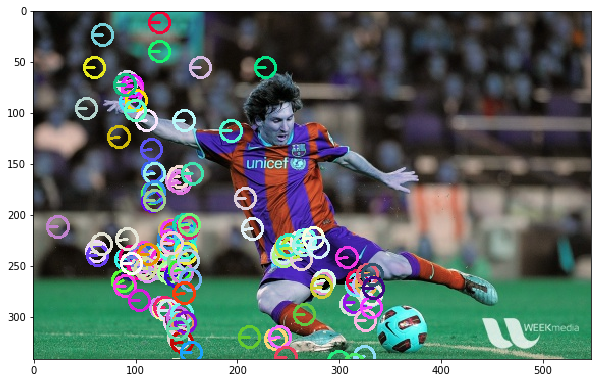

In [4]:
image = cv2.imread("../resources/messi.jpg")

sift = SIFT(image, 4, 2)

sift.build_scale_space()
sift.detect_extrema()
sift.assign_orientation()
sift.generate_features()

out = sift.draw_keypoints()

fig = plt.figure()
fig.set_size_inches(10, 10)
fig.add_subplot(1,1,1)
plt.imshow(out)
plt.show()

# SURF (Speeded-Up Robust Features)
It's a bit faster approach for detecting features.

<u>Comparison with SIFT</u>:
- Instead of approximating LoG with DoG, here, it's done with Box Filter.
- <b>Orientation Assignment</b>- Uses wavelet responses in horizontal and vertical direction for a 6sx6s (s is scale) neigbourhood. Adequate gaussian weights are applied and then plotted in a space. The dominant orientation is estimated by calculating the sum of all responses within a sliding orientation window of angle 60 degrees.
<img src="../resources/surf_orientation.jpg">
- <b>Generating Features</b>- A neighbourhood of 20sx20s is taken around keypoint. It's divided into 4x4 sub-blocks. For each sub-block, horizontal and vertical responses are taken and we get feature vector
$$v = (\sum d_{x}, \sum d_{y}, \sum |d_{x}|, \sum |d_{y}|)$$
- Not good with viewpoint / illumination variance.

(148, 128) (148, 64)


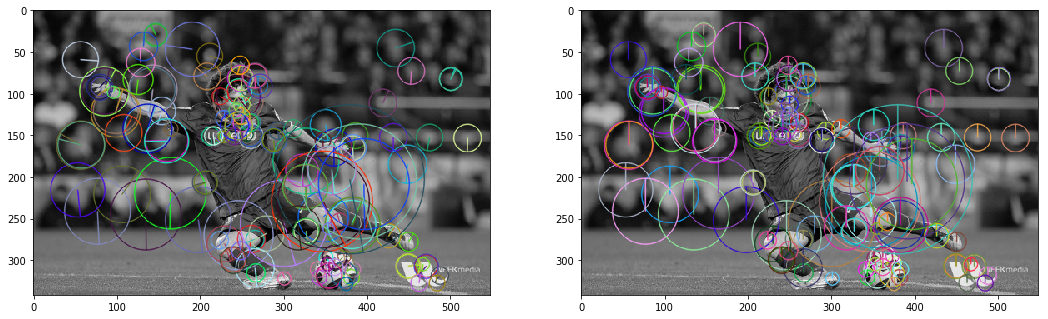

In [5]:
image = cv2.imread("../resources/messi.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

surf_slow = cv2.xfeatures2d.SURF_create(hessianThreshold=4000, upright=0, extended=True)
surf_fast = cv2.xfeatures2d.SURF_create(hessianThreshold=4000, upright=1, extended=False)

keypoints1, descriptors1 = surf_slow.detectAndCompute(gray, mask=None)
keypoints2, descriptors2 = surf_fast.detectAndCompute(gray, mask=None)

print(descriptors1.shape, descriptors2.shape)

flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT
try:
    out1 = cv2.drawKeypoints(gray, keypoints1, flags=flags)
    out2 = cv2.drawKeypoints(gray, keypoints2, flags=flags)
except:
    out1 = image.copy()
    out2 = image.copy()
    cv2.drawKeypoints(gray, keypoints1, out1, flags=flags)
    cv2.drawKeypoints(gray, keypoints2, out2, flags=flags)

fig = plt.figure()

fig.set_size_inches(18, 10)

fig.add_subplot(1,2,1)
plt.imshow(out1)
fig.add_subplot(1,2,2)
plt.imshow(out2)

plt.show()

# FAST (Features from Accelerated Segmented Test)
Real-time feature detection.
### Algorithm
- Select a pixel p (which is to be identified as keypoint). Let it's intensity be I<sub>p</sub>
- Select appropriate threshold value t.
- Take a circular neighborhood consisting of 16 pixels around the selected pixel
<img src="../resources/fast_neighbour.jpg">
- Pixel p is considered a corner if there exists a set of n(=12) contiguous pixels in the circular neigbourhood such that either all have intensities greater than I<sub>p</sub> + t or lower than I<sub>p</sub> - t
- High speed test says to examine only pixels 1, 5, 9, 13 and if atleast three of these are either brighter than I<sub>p</sub> + t or darker than I<sub>p</sub> - t, then p is a corner
### Applying ML
- Run FAST algorithm over a training dataset to find feature points.
- For every feature point, store the 16 pixels around it as a vector (feature vector P).
- For each pixel x in the feature vector P
<img src="../resources/pixel_state.jpg">
- Depending on the pixel states, each feature vector is divided into 3 subsets: P<sub>d</sub>, P<sub>s</sub>, P<sub>b</sub>
- Define a boolean K<sub>p</sub> which is true if p is corner, otherwise false
- ID3 algorithm (decision tree classifier) is used to query each subset using knowledge variable K<sub>p</sub>
- Then pixel x is selected which yields most information about whether p is a corner, measured by entropy of K<sub>p</sub>
- This is done recursively to all subsets until its entropy becomes zero
### Non-maximal Suppression
- Compute a score function V for all detected feature vectors. V is sum of absolute difference between p and it's 16 neighbour pixels.
- Consider two adjacent keypoints, comapre their score and discard the one with lower score.

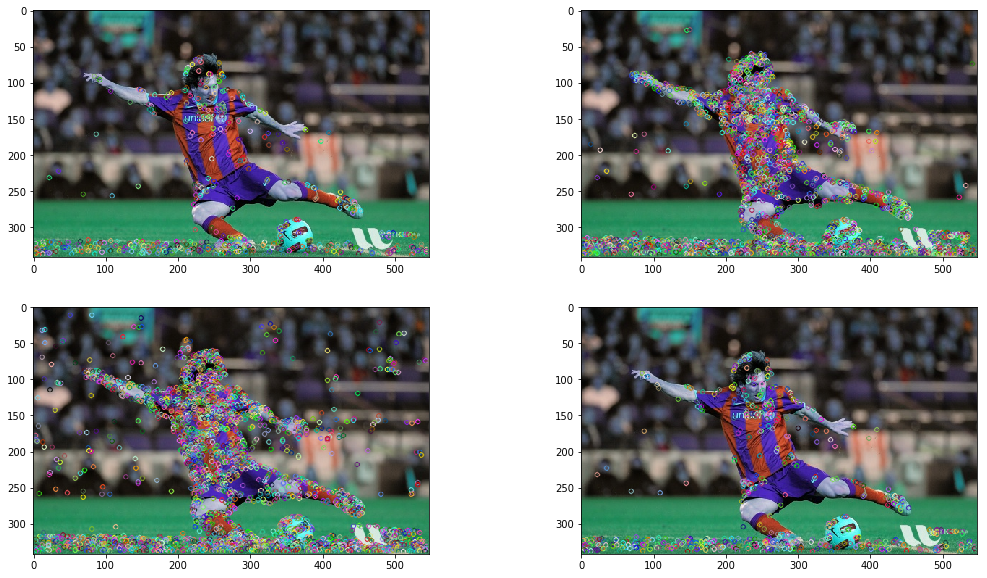

In [6]:
# In order to avoid resampling, we consider a 3 by 3 score patch on each layer.
# Unluckily, detectAndCompute doesn't work in opencv@3.x.x :'(

image = cv2.imread("../resources/messi.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT

fig = plt.figure()
fig.set_size_inches(18, 10)

fast = cv2.FastFeatureDetector_create(type=cv2.FastFeatureDetector_TYPE_5_8)
keypoints = fast.detect(gray, mask=None)
try:
    out = cv2.drawKeypoints(image, keypoints, flags=flags)
except:
    out = image.copy()
    cv2.drawKeypoints(image, keypoints, out, flags=flags)
fig.add_subplot(2, 2, 1)
plt.imshow(out)

fast = cv2.FastFeatureDetector_create(type=cv2.FastFeatureDetector_TYPE_7_12)
keypoints = fast.detect(gray, mask=None)
try:
    out = cv2.drawKeypoints(image, keypoints, flags=flags)
except:
    out = image.copy()
    cv2.drawKeypoints(image, keypoints, out, flags=flags)
fig.add_subplot(2, 2, 2)
plt.imshow(out)

fast = cv2.FastFeatureDetector_create(type=cv2.FastFeatureDetector_TYPE_9_16)
keypoints = fast.detect(gray, mask=None)
try:
    out = cv2.drawKeypoints(image, keypoints, flags=flags)
except:
    out = image.copy()
    cv2.drawKeypoints(image, keypoints, out, flags=flags)
fig.add_subplot(2, 2, 3)
plt.imshow(out)

fast = cv2.FastFeatureDetector_create(type=cv2.FastFeatureDetector_TYPE_5_8, nonmaxSuppression=False)
keypoints = fast.detect(gray, mask=None)
try:
    out = cv2.drawKeypoints(image, keypoints, flags=flags)
except:
    out = image.copy()
    cv2.drawKeypoints(image, keypoints, out, flags=flags)
fig.add_subplot(2, 2, 4)
plt.imshow(out)

plt.show()

# BRISK (Binary Robust Invariant Scalable Keypoints)
1. <u>Scale-Space Keypoint Detection</u> - BRISK detector estimates the true scale of each keypoint in the continuous scale-space. The scale-space pyramid layers consist of n octaves c<sub>i</sub> and n intra-octaves d<sub>i</sub>, for i = {0, 1, . . . , n − 1} and typically n = 4. The octaves are formed by progressively half-sampling the original image (corresponding to c<sub>0</sub>). Each intra-octave d<sub>i</sub> is located in-between layers c<sub>i</sub> and c<sub>i+1</sub>. d<sub>0</sub> is calculated by downsampling original image c<sub>0</sub> by a factor of 1.5. The detection of maxima across the scale axis at octave c<sub>0</sub> is a special case: in order to obtain the FAST scores for a virtual intra-octave d<sub>−1</sub> below c0, we apply the FAST 5-8 mask on c<sub>0</sub>. We first fit a 2D quadratic function in the least-squares sense to each of the three scores-patches (obtained in the layer of the keypoint, the one above, and the one below) resulting in three sub-pixel refined maxima. Next, these refined scores are used to fit a 1D parabola along the scale axis yielding the final score estimate and scale estimate at its maximum. As a final step, we re-interpolate the image coordinates between the patches in the layers next to the determined scale.
2. <u>Descriptors</u> - BRISK sampling pattern is composed out of concentric rings. When considering each sampling point, we take a small patch around it and apply Gaussian smoothing. When using this sampling pattern, we distinguish between short pairs and long pairs. Short pair are pairs of sampling points that their distance is below a certain threshold d_max and long pairs are pairs of sampling points that their distance is above a certain different threshold d_min, where d_min > d_max. Long pairs are used in BRISK to determine orientation and short pairs are used for the intensity comparisons that build the descriptor. For computing the orientation of the keypoint, BRISK uses local gradients between the sampling pairs. To compute orientation, we sum up all the local gradients between all the long pairs and take arctan(gy/gx) – the arctangent of the the y component of the gradient divided by the x component of the gradient. This gives up the angle of the keypoint. BRISK takes the set of short pairs, rotate the pairs by the orientation computed earlier and makes comparisons of the form: <img src="../resources/brisk.jpg"> For each short pair it takes the smoothed intensity of the sampling points and checked whether the smoothed intensity of the first point in the pair is larger than that of the second point.

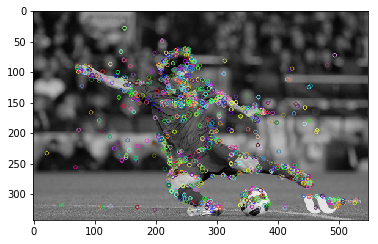

In [7]:
image = cv2.imread("../resources/messi.jpg", cv2.IMREAD_GRAYSCALE)

brisk = cv2.BRISK_create()
keypoints = brisk.detect(image)

image = cv2.drawKeypoints(image, keypoints, image, flags=flags)
plt.imshow(image)
plt.show()

# BRIEF (Binary Robust Independent Elementary Features)
One bad thing about SIFT and SURF techniques is that they become super slow and memory heavy, when creating vectors for thousands of features (512 bytes and 256 bytes per descriptor respectively). Many dimensionality reduction methods were invented to boost this process, like LDA(Latent Dirichilet Allocation), PCA(Prinicipal Component Analysis), LSH (Locality Sensitive Hashing), LDE(Linear Discriminant Embedding), which we'll try to discuss later in deep too. But, the memory problem still persists.

**Short note on LSH to help understand BRIEF: Locality Sensitive Hashing (LSH) helps to turn ﬂoating-point vectors into binary strings. This is done by thresholding the vectors after multiplication with an appropriate matrix. Similarity between descriptors is then measured by the Hamming distance between the corresponding binary strings. This is very fast because the Hamming distance can be computed very eﬃciently with a bitwise XOR operation followed by a bit count.**

To the resuce, comes BRIEF, which is both memory and speed efficient!

It works over LSH but without finding descriptors for our features. It takes smoothened image patch and selects a set of n<sub>d</sub>(x, y) location pairs. There are a lot of ways for this selection. Let's discuss one of them. We uniformly choose a point from -S/2 to S/2 (where S is the patch size). We select one more point in the same way. So, now say, we have (x1, y1) and (x2, y2) points with us. We compare the intensity values of these points - if first is larger, we assign the first point, boolean value of '1', if smaller, then we assign '0'. This is applied for all the n<sub>d</sub> location pairs to get a n<sub>d</sub>-dimensional bitstring (or boolean vector). [n<sub>d</sub> = 128, 256, 512 seems to yield good results]

### Smoothing
As we've seen, we take only the information at a single pixel into account(while assigning a boolean value), this renders the technique noise-sensitive. By pre-smoothing the patch, this sensitivity can be reduced. It's suggested to use a 9x9 Gaussian kernel with variance = 2 (should be [1,3]).

(163, 32)
[[161  57  14 ..., 215 194   7]
 [183 166 181 ..., 130  61   8]
 [ 76 206 137 ...,  64 223 163]
 ..., 
 [235 182  63 ...,  60  36 220]
 [203 182 185 ...,  60  36 220]
 [223 183 185 ...,  52  53 152]]


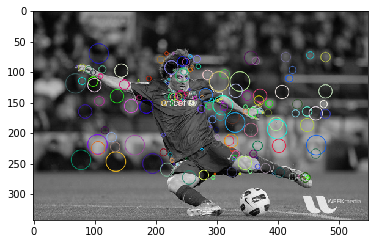

In [8]:
image = cv2.imread("../resources/messi.jpg", cv2.IMREAD_GRAYSCALE)

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_star = star.detect(image, mask=None)
keypoints_brief, desc = brief.compute(image, keypoints_star)

print(desc.shape)
print(desc)

out = image.copy()
flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
out = cv2.drawKeypoints(image, keypoints_star, out, flags=flags)
plt.imshow(out)
plt.show()

# ORB (Oriented FAST and Rotated BRIEF)
As the name suggests, ORB is a fusion of FAST and BRiEF. Uses FAST to calculate keypoints and filters top N among them using harris-corner. It has a pyramid structure to produce multi-scale features, but 'FAST' keypoints are not rotation variant. This is somewhat fixed by assigning direction of the vector, from located keypoint as center of path to weighted intensity centroid of a patch, to the orientation of the keypoint. ORB uses BRIEF descriptors with a modification of steering the BRIEF descriptors according to orientation of keypoints, in order to introduce rotation invariance of descriptors.

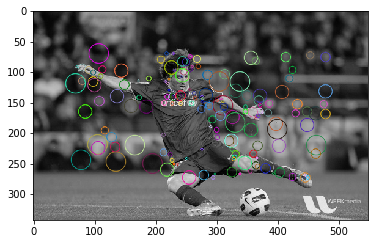

In [9]:
cv2.ocl.setUseOpenCL(False)  # for opencv bug
image = cv2.imread("../resources/messi.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints = orb.detect(image, mask=None)
keypoints, descriptors = orb.compute(image, keypoints)

out = image.copy()
out = cv2.drawKeypoints(image, keypoints_star, out, flags=flags)

plt.imshow(out, cmap='gray')
plt.show()

# DAISY Descriptor
The DAISY local image descriptor is based on gradient orientation histograms similar to the SIFT descriptor. It is formulated in a way that allows for fast dense extraction which is useful for e.g. bag-of-features image representations.

For a given input image, we first compute eight orientation maps, G, one for each quantized direction, where G<sub>o</sub>(u, v) equals the image gradient at location (u, v) for direction o if it is bigger than zero, else zero. This is to preserve the polarity of the intensity change. Each orientation map is then convolved several times with Gaussian kernels of different Σ values to obtain convolved orientation maps for different sized regions.

At each pixel location, DAISY consists of a vector made of values from the convolved orientation maps located on concentric circles centered on the location, and where the amount of Gaussian smoothing is proportional to the radius of the circles.

# FREAK (Fast RETina Keypoint) Descriptor
FREAK suggests to use the retinal sampling grid which is also circular with the difference of having higher density of points near the center. The density of points drops exponentially. Each sampling point is smoothed with a Gaussian kernel where the radius of the circle illustrates the size of the standard deviation of the kernel. FREAKS follows ORB’s approach and tries to learn the pairs by maximizing variance of the pairs and taking pairs that are not correlated.

We'll see use of descriptors in next notebook for feature matching.

# A-KAZE (Accelerated-KAZE)
KAZE Features is a novel 2D feature detection and description method that operates completely in a nonlinear scale space. Previous methods such as SIFT or SURF find features in the Gaussian scale space (particular instance of linear diffusion). However, Gaussian blurring does not respect the natural boundaries of objects and smoothes in the same degree details and noise when evolving the original image through the scale space.

By means of nonlinear diffusion one can detect and describe features in nonlinear scale spaces keeping important image details and removing noise as long as the image is evolved in the scale space. It uses variable conductance diffusion. The nonlinear scale space is build efficiently by means of Additive Operator Splitting (AOS) schemes, which are stable for any step size and are parallelizable.

Accelerated-KAZE Features uses Fast Explicit Diffusion (FED) embedded in a pyramidal framework to speed-up dramatically the nonlinear scale space computation. In addition, a robust Modified-Local Difference Binary (M-LDB) descriptor that exploits gradient information from the nonlinear scale space is calculated.

In [10]:
image1 = cv2.imread("../resources/img1.ppm", cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread("../resources/img3.ppm", cv2.IMREAD_GRAYSCALE)

homography = np.loadtxt("../resources/H1to3p")
print(homography)

[[  7.62858980e-01  -2.99229290e-01   2.25671230e+02]
 [  3.34434730e-01   1.01439010e+00  -7.69999730e+01]
 [  3.46630910e-04  -1.43645240e-05   1.00000000e+00]]


In [11]:
akaze = cv2.AKAZE_create()
keypoints1, descriptors1 = akaze.detectAndCompute(image1, mask=None)
keypoints2, descriptors2 = akaze.detectAndCompute(image2, mask=None)

print(descriptors1.shape, descriptors2.shape)

(2947, 61) (3513, 61)


In [12]:
matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING)
matches = matcher.knnMatch(descriptors1, descriptors2, 2)

match_ratio = 0.8
matched1, matched2 = [], []

for i in range(len(matches)):
    f = matches[i][0]
    
    dist1, dist2 = matches[i][0].distance, matches[i][1].distance
    if dist1 < match_ratio * dist2:
        matched1.append(keypoints1[f.queryIdx])
        matched2.append(keypoints2[f.trainIdx])

In [13]:
kp_match1, kp_match2, good_match = [], [], []

# validate the matches
for i in range(len(matched1)):
    mat = np.ones((3, 1), dtype=np.float64)
    mat[0], mat[1] = matched1[i].pt
    mat = np.dot(homography, mat)
    mat /= mat[2]
    
    dist = cv2.sqrt(cv2.pow(mat[0] - matched2[i].pt[0], 2) + cv2.pow(mat[1] - matched2[i].pt[1], 2))
    if dist < 2.5:
        idx = len(kp_match1)
        kp_match1.append(matched1[i])
        kp_match2.append(matched2[i])
        good_match.append(cv2.DMatch(idx, idx, 0))

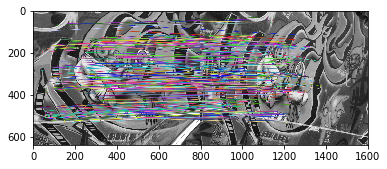

In [14]:
out = cv2.drawMatches(image1, kp_match1, image2, kp_match2, good_match, None)
plt.imshow(out)
plt.show()